# 개인 프로젝트 예시


## OPEN API를 활용한 네이버 뉴스 텍스트 분석
- 1. 네이버 오픈 API로 기사 URL 크롤링
- 2. bs4 + selenium으로 기사 제목 및 내용 크롤링

In [1]:
import os
import sys
import urllib.request
import requests

news_data = []
page_count = 3

client_id = "KJKACCZwmz8QlKStuCTn"
client_secret = "5n9ojiieaU"

encText = urllib.parse.quote("메이플스토리")

for idx in range(page_count):
    # json 결과
    url = "https://openapi.naver.com/v1/search/news?query=" + encText + "&start=" + str(idx * 10 + 1)
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if(rescode==200):
    #    response_body = response.read()
        result = requests.get(response.geturl(),
                              headers={"X-Naver-Client-Id":client_id,
                                       "X-Naver-Client-Secret":client_secret}
                             )
        news_data.append(result.json())
    #    print(response_body.decode('utf-8'))
    else:
        print("Error Code:" + rescode)

### 크롤링한 데이타 살펴보기

- 온라인 json 뷰어 이용하기 : http://jsonviewer.stack.hu/

In [2]:
# print(news_data)
# print(len(news_data))
# print(news_data[0])
# print(news_data[0]['items'])
# print(len(news_data[0]['items']))
# print(news_data[0]['items'][2])
print(news_data[0]['items'][7]['link'])

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=417&aid=0000666941


### 네이버 뉴스 하이퍼링크만 리스트로 저장하기

In [3]:
naver_news_link = []

for page in news_data:
    #print(page)
    page_news_link = []
    
    for item in page['items']:
        #print(item)
        temp_link = item['link']
        #print(temp_link)
        if "naver" in temp_link:
            page_news_link.append(temp_link)
    
    naver_news_link.append(page_news_link)
        

# 사이트 링크만 가져오기
for page in naver_news_link:
    for link in page:
        print(link)

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=277&aid=0004862408
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=092&aid=0002215644
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=028&aid=0002535664
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=417&aid=0000666941
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=008&aid=0004554668
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=008&aid=0004554667
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=008&aid=0004554664
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=081&aid=0003169804
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=417&aid=0000666840
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=020&aid=0003343430
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=018&aid=0004871634
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&

### 라이브러리 불러오기

In [4]:
import pandas as pd
import numpy as np
from selenium import webdriver
# 진행바 나오는 패키지
from tqdm import tqdm_notebook
import requests
import pickle
import re
import ast

from bs4 import BeautifulSoup 
from urllib.request import urlopen
import urllib
import time

### 셀레니움을 사용하기 위해 가상 크롬드라이버 다운로드
- 크롬 드라이브 다운로드 : https://chromedriver.chromium.org/downloads

In [5]:
from selenium import webdriver

driver = webdriver.Chrome('./driver/chromedriver.exe')

### 수집한 네이버 뉴스 사이트를 방문하여 뉴스 타이틀과 본문내용 가져오기

In [6]:
naver_news_title = []
naver_news_content = []


for n in tqdm_notebook(range(len(naver_news_link))):
    #print(n)
    news_page_title = []
    news_page_content = []
    
    for idx in tqdm_notebook(range(len(naver_news_link[n]))):        
        
    ########### 긁어온 URL로 접속하기 ############    
        try:
            driver.get(naver_news_link[n][idx])
            print(naver_news_link[n][idx])
            
        except:
            print("Timeout!")
            continue        
        
        try:
            response = driver.page_source
            
        except UnexpectedAlertPresentException:
            driver.switch_to_alert().accept()
            print("게시글이 삭제된 경우입니다.")
            continue
        
        soup = BeautifulSoup(response, "html.parser")
        
        ###### 뉴스 타이틀 긁어오기 ######        
        title = None
        
        try:
            item = soup.find('div', class_="article_info")
            title = item.find('h3', class_="tts_head").get_text()
            #print(title)

        except:
            title = "OUTLINK"
        
        #print(title)
        news_page_title.append(title)
        
        
        ###### 뉴스 본문 긁어오기 ######        
        doc = None
        text = ""
                
        data = soup.find_all("div", {"class" : "_article_body_contents"})
        if data:
            for item in data:

                text = text + str(item.find_all(text=True)).strip()
                text = ast.literal_eval(text)
                doc = ' '.join(text)
   
        else:
            doc = "OUTLINK"
            
        news_page_content.append(doc.replace('\n', ' '))

                
    naver_news_title.append(news_page_title)
    naver_news_content.append(news_page_content)

    time.sleep(2)
    
    
print(naver_news_title[0])
print("==================================")
print(naver_news_content[0])

<ipython-input-6-1b13de154505>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(naver_news_link))):


<ipython-input-6-1b13de154505>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(naver_news_link[n]))):


https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=277&aid=0004862408
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=092&aid=0002215644
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=028&aid=0002535664
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=417&aid=0000666941



https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=008&aid=0004554668
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=008&aid=0004554667
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=008&aid=0004554664
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=081&aid=0003169804
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=417&aid=0000666840
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=020&aid=0003343430



https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=018&aid=0004871634
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=236&aid=0000211062
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=009&aid=0004760657
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=081&aid=0003169702


['[이슈! Q&A]"수천만원 써도 아이템 확률은 \'깜깜이\'…이용자 뿔났다', '넥슨 메이플스토리, 4월 중 간담회...성난 이용자 달래기 총력', '‘1등 없는 로또’에 10년 헛돈…넥슨 발 ‘사기’ 논란에 게임업계 초긴장', '거듭 고개 숙인 넥슨 "4월 중 간담회 개최한다"']
['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    [아시아경제 부애리 기자] 넥슨의 인기게임 ‘메이플스토리’가 지난달 확률형 아이템 조작 논란에 휩싸이면서 그간 이용자들 사이에서 쌓여있던 불만이 폭발했다. 이용자들은 게임 아이템에 대한 확률 정보를 투명하게 공개하라며 넥슨 본사에서 ‘트럭시위’를 벌였다. 확률형 아이템을 규제 해달라는 청와대 국민청원까지 올라왔다. 국내 게임사들의 주요 매출원인 확률형 아이템에 대한 이용자들의 반발이 커지면서 17조원 규모에 달하는 국내 게임 시장이 들썩이고 있다. Q.확률형 아이템, 왜 논란인가 A .확률형 아이템은 일종의 ‘뽑기’ 개념으로 이해하면 쉽다. 게임 이용자가 어떤 아이템을 획득하게 될 지 구입 전까지 알 수 없는 상품이다. 복권 당첨 수준의 낮은 확률이 문제가 되면서 이용자에게 과도한 지

In [7]:
print(naver_news_title[0])

['[이슈! Q&A]"수천만원 써도 아이템 확률은 \'깜깜이\'…이용자 뿔났다', '넥슨 메이플스토리, 4월 중 간담회...성난 이용자 달래기 총력', '‘1등 없는 로또’에 10년 헛돈…넥슨 발 ‘사기’ 논란에 게임업계 초긴장', '거듭 고개 숙인 넥슨 "4월 중 간담회 개최한다"']


In [8]:
print(naver_news_content[0])

['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    [아시아경제 부애리 기자] 넥슨의 인기게임 ‘메이플스토리’가 지난달 확률형 아이템 조작 논란에 휩싸이면서 그간 이용자들 사이에서 쌓여있던 불만이 폭발했다. 이용자들은 게임 아이템에 대한 확률 정보를 투명하게 공개하라며 넥슨 본사에서 ‘트럭시위’를 벌였다. 확률형 아이템을 규제 해달라는 청와대 국민청원까지 올라왔다. 국내 게임사들의 주요 매출원인 확률형 아이템에 대한 이용자들의 반발이 커지면서 17조원 규모에 달하는 국내 게임 시장이 들썩이고 있다. Q.확률형 아이템, 왜 논란인가 A .확률형 아이템은 일종의 ‘뽑기’ 개념으로 이해하면 쉽다. 게임 이용자가 어떤 아이템을 획득하게 될 지 구입 전까지 알 수 없는 상품이다. 복권 당첨 수준의 낮은 확률이 문제가 되면서 이용자에게 과도한 지출을 초래한다는 비판을 받아왔다. 게임사들은 한국게임정책자율기구(GSOK)의 자율규제에 따라 일반 모델인 ‘유료 캡슐형 아이템 확률’을 홈페이지에 공개하고 있다. 하지만 게임 내에는 다양한 버전의 확률형 아이템이 존재한다. 확률형 아이템을 모아서 다시 아이템을 만드는 2중 구조의 확률형 아이템, 무료·유료 아이템 결합 아이템, 유료 강화 확률 등에 대한 정보는 부족한 실정이다. 이용자들은 많게는 수천만원을 투자하는 고가의 아이템에 대한 확률 정보도 모르는 상태로 돈을 써야한다는 사실에 불만을 터뜨리고 있다. Q.어떤 게임에서 문제가 불거졌나 A . 최근 논란이 된 넥슨 메이플스토리의 ‘환생의 불꽃’, 엔씨소프트 리니지2M의 ‘신화무기’ 등이 대표적이다. 환생의 불꽃은 확률형 아이템으로 이를 사용할 경우 이용자는 여러 옵션을 획득해 자신이 가진 장비를 업그레이드 할 수 있다. 이용자는 원하는 옵션이 나올 때까지 ‘환생의 불꽃’을 구매한다. 하지만 ‘환생의 불꽃’의 옵션 등장 확률에 대해 이용자들은

In [9]:
print(len(naver_news_title[0]))
print(len(naver_news_content[0]))

4
4


### 피클형태로 저장

In [10]:
with open("./data/naver_news_title.pk", "wb") as f:
    pickle.dump(naver_news_title, f)
    
with open("./data/naver_news_content.pk", "wb") as f:
    pickle.dump(naver_news_content, f)

-------------------------------
## 형태소 분석기 제작하기
- 1. 사용할 형태소 분석기 불러오기
- 2. 텍스트 전처리 하기
- 3. 형태소 / POS tagging 하기

### 형태소 불러오기

In [11]:
from konlpy.tag import Okt
import re

okt = Okt()

# 경고 알림이 뜨면 모두 무시
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 텍스트 전처리

In [12]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)            
    return SW

def text_tokenizing(doc):    
    # list comprehension을 풀어서 쓴 코드.1)     
#     tokenized_doc = []
    
#     for word in okt.morphs(doc):
#         if word not in SW and len(word) > 1:
#             tokenized_doc.append(word)
    
#     return tokenized_doc    
    return [word for word in okt.morphs(doc) if word not in SW and len(word) > 1]

In [13]:
text = """5G 이동통신망을 빌려 사용하는 ‘5G 알뜰폰’이 올해 도입되고, 내년부터는 의무화된다.
정부는 알뜰폰 사업자(MNVO)가 통신사(MNO)에 통신망을 빌리는 비용(도매대가)을 지난해보다 큰 폭으로 낮춰, 알뜰폰 요금 인하를 유도하기로 했다. 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다.
과학기술정보통신부는 알뜰폰 활성화 추진대책을 25일 발표했다. 알뜰폰 가입자는 800만명으로 이동통신 시장의 12%를 차지한다. 2011년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다. 하지만 지난해 5월 통신 3사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다.
우선 올해 안에 3개 이상의 5G 알뜰폰이 시장에 나온다. 통신사가 5G망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다. 앞서 LG유플러스는 오는 10월 알뜰폰 사업을 시작하는 KB국민은행에 5G망을 제공한다고 밝힌 바 있다. SK텔레콤와 KT도 특정 제휴사를 선택해 올해 안에 5G 알뜰폰을 내놓기로 했다.
내년부터는 5G 알뜰폰 제공이 의무화된다. 지난 22일자로 종료된 도매제공 의무제도의 유효기간을 2022년 9월22일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면, 관련 고시를 개정해 SK텔레콤의 5G망 도매제공을 의무화하겠다는 것이다.
과기정통부 관계자는 “SK텔레콤이 자사와 계약을 맺은 13개 알뜰폰 사업자에게 5G망을 의무 제공하면, 그 외 31개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 KT와 LG유플러스도 5G망을 제공하게 될 것”이라고 내다봤다.
알뜰폰 사업자가 상품을 만드는 방식 크게 2가지다. 하나는 통신사로부터 음성·문자·데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식(종량제 도매제공)이다. 이를 위해 정부는 도매대가 인하율을 음성 17.8%, 데이터 19.2%, 단문메시지 1.15%로, 지난해 음성 15.1%, 데이터 19.1%, 단문메시지 1.13%에 비해 높여 잡았다.
또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서, 그 차액의 범위에서 저렴한 요금제를 내놓는 방식(수익배분 도매제공)이다. 정부는 SK텔레콤의 준보편 요금제인 ‘T플랜 요금제’를 알뜰폰 사업자가 재판매할 수 있게 했다. 기존에 SK텔레콤이 도매제공했던 ‘밴드데이터 요금제’의 최고구간의 대가도 1.5%포인트 낮췄다.
알뜰폰 업계는 대체로 반기는 분위기지만, 알뜰폰 시장을 살릴 수 있을지에는 의구심을 갖고 있다. 업계 관계자는 “도매대가 인하율이 크고, 5G망을 제공하는 것은 긍정적”이라면서도 “수익배분 도매제공의 의무화, 설비를 가진 업체에 대한 접속료 정산 도입 등의 제도적 개선이 필요하다”고 말했다."""

In [14]:
SW = define_stopwords("./data/stopwords-ko.txt")

cleaned_text = text_cleaning(text)
print("전처리 결과 : ", cleaned_text)

tokenized_text = text_tokenizing(cleaned_text)
print("\n형태소 분석 결과 : ", tokenized_text)

전처리 결과 :   이동통신망을 빌려 사용하는  알뜰폰이 올해 도입되고 내년부터는 의무화된다정부는 알뜰폰 사업자가 통신사에 통신망을 빌리는 비용도매대가을 지난해보다 큰 폭으로 낮춰 알뜰폰 요금 인하를 유도하기로 했다 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다과학기술정보통신부는 알뜰폰 활성화 추진대책을 일 발표했다 알뜰폰 가입자는 만명으로 이동통신 시장의 를 차지한다 년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다 하지만 지난해 월 통신 사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다우선 올해 안에 개 이상의  알뜰폰이 시장에 나온다 통신사가 망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다 앞서 유플러스는 오는 월 알뜰폰 사업을 시작하는 국민은행에 망을 제공한다고 밝힌 바 있다 텔레콤와 도 특정 제휴사를 선택해 올해 안에  알뜰폰을 내놓기로 했다내년부터는  알뜰폰 제공이 의무화된다 지난 일자로 종료된 도매제공 의무제도의 유효기간을 년 월일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면 관련 고시를 개정해 텔레콤의 망 도매제공을 의무화하겠다는 것이다과기정통부 관계자는 텔레콤이 자사와 계약을 맺은 개 알뜰폰 사업자에게 망을 의무 제공하면 그 외 개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 와 유플러스도 망을 제공하게 될 것이라고 내다봤다알뜰폰 사업자가 상품을 만드는 방식 크게 가지다 하나는 통신사로부터 음성문자데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식종량제 도매제공이다 이를 위해 정부는 도매대가 인하율을 음성  데이터  단문메시지 로 지난해 음성  데이터  단문메시지 에 비해 높여 잡았다또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서 그 차액의 범위에서 저렴한 요금제를 내놓는 방식수익배분 도매제공이다 정부는 텔레콤의 준보편 요금제인 플랜 요금제를 알뜰폰 사업자가 재판매할 수 있게 했다 기존에 텔레콤이 도매제공했던 

----------------------------
## 피클형태 데이타 읽어와서 빈도 챠트와 워드 클라우드 그리기

### 데이타 전처리와 데이타 불러오기 함수

In [15]:
from tqdm import tqdm_notebook # progress bar
from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

ModuleNotFoundError: No module named 'gensim'

In [ ]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []
    
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
        
    for page in temp_corpus:
        corpus += page
    
    return corpus

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)            
    return SW


def text_tokenizing(doc):
    return [word for word in okt.nouns(doc) if word not in SW and len(word) > 1]

In [21]:
input_file_name = "./data/naver_news_content.pk"
documents = read_documents(input_file_name)
documents

당시 원고 측 변호사는 "재판부가 확률형 아이템이 실제로 얼마나 구현됐고 이벤트성 아이템도 실제로 구현되기는 했는지에 대해 검증조차 해 보지 않았다"며 "확률형 아이템이 구현되는 알고리즘이 게임사의 영업비밀에 해당하더라도 \'비밀유지명령\' 등을 통해 재판부가 적극적으로 확인하는 절차는 거쳤어야 한다"고 지적했다. 결국 법원은 게임 내에서 실제 확률형 아이템이 어떻게 구현되는 지에 대한 검증도 없이 양측 주장만으로 서류상 재판을 한 셈이다.  start_block ━ "게임사 상대 소송해도 \'정보비대칭\'으로 승소 어려워" ━ end_block 지난해 8월 선고된 \'리니지2 레볼루션\'에 대한 \'원상회복 청구\'소송도 이용자  208 명이 패소했다.  이용자들은 게임내에서 확률형 아이템을 구매하도록 한 것에 대해 "사회질서에 어긋나거나 불공정한 법률행위로 무효"라며 구매대금 총  800 여만원을 반환하라고 주장했다.  이 게임에선 확률형 아이템만 문제가 된 건 아니다. 확률형 아이템을 포함해 아이템을 구매하도록 하는 이용계약이 사행성을 조장했고, 게임사가 결제금액 제한 등 최소한의 보호조치를 취하지 않았다는 게 이용자들의 주장이었다. 이에 대해 재판부는 "유료 아이템 구매를 유도한 면이 있더라도 사기업으로서 게임 서비스를 무상으로 제공하는 피고가 이윤 추구 방법으로 용인된 수준을 벗어났다고 볼 증거가 없다"고 결론 내렸다. 이어 "확률형 아이템을 포함한 게임 아이템 구매계약이 선량한 풍속이나 사회질서를 위반하는 행위라고 보기도 어렵다"고 했다.  법률전문가들은 대형 게임사를 상대로 한 소비자 소송은 정보 비대칭으로 일방적으로 게임사에 유리하기때문에 재판부가 적극적으로 \'석명권\'을 발휘해 게임사가 숨길수 있는 관련 증거자료를 확보해야만 한다고 지적한다 대형 로펌의 한 게임산업 전문 변호사는 "확률형 아이템을 두고 자잘한 소송이 몇가지 있었던 걸로 알지만 현재 상황에서 이용자가 게임사를 상대로 승소하기를 바라는 건 어렵다"며 "소비자불만은 높지만 이런 방

In [22]:
SW = define_stopwords("./data/stopwords-ko.txt")
SW

{'가\n',
 '가까스로\n',
 '가령\n',
 '각\n',
 '각각\n',
 '각자\n',
 '각종\n',
 '갖고말하자면\n',
 '같다\n',
 '같이\n',
 '개의치않고\n',
 '거니와\n',
 '거바\n',
 '거의\n',
 '것\n',
 '것과 같이\n',
 '것들\n',
 '게다가\n',
 '게우다\n',
 '겨우\n',
 '견지에서\n',
 '결과에 이르다\n',
 '결국\n',
 '결론을 낼 수 있다\n',
 '겸사겸사\n',
 '고려하면\n',
 '고로\n',
 '곧\n',
 '공동으로\n',
 '과\n',
 '과연\n',
 '관계가 있다\n',
 '관계없이\n',
 '관련이 있다\n',
 '관하여\n',
 '관한\n',
 '관해서는\n',
 '구\n',
 '구체적으로\n',
 '구토하다\n',
 '그\n',
 '그들\n',
 '그때\n',
 '그래\n',
 '그래도\n',
 '그래서\n',
 '그러나\n',
 '그러니\n',
 '그러니까\n',
 '그러면\n',
 '그러므로\n',
 '그러한즉\n',
 '그런 까닭에\n',
 '그런데\n',
 '그런즉\n',
 '그럼\n',
 '그럼에도 불구하고\n',
 '그렇게 함으로써\n',
 '그렇지\n',
 '그렇지 않다면\n',
 '그렇지 않으면\n',
 '그렇지만\n',
 '그렇지않으면\n',
 '그리고\n',
 '그리하여\n',
 '그만이다\n',
 '그에 따르는\n',
 '그위에\n',
 '그저\n',
 '그중에서\n',
 '그치지 않다\n',
 '근거로\n',
 '근거하여\n',
 '기대여\n',
 '기점으로\n',
 '기준으로\n',
 '기타\n',
 '까닭으로\n',
 '까악\n',
 '까지\n',
 '까지 미치다\n',
 '까지도\n',
 '꽈당\n',
 '끙끙\n',
 '끼익\n',
 '나\n',
 '나머지는\n',
 '남들\n',
 '남짓\n',
 '너\n',
 '너희\n',
 '너희들\n',
 '네\n',
 '넷\n',
 '년\n',
 '논하지 않다\n',
 '놀라다\n',

In [23]:
cleaned_text = text_cleaning(documents)
cleaned_text

게 성장하기 위해 겪는 성장통으로 봐 달라는 주문이 동시에 나온다 비정상 부분의 정상화를 위해 노력하는 과정에서 불거졌다는 점을 감안해달라는 것이다 게임업체들은 이용자들을 상대로 사행 행위를 조장하거나 사기 행위를 벌인 것으로 간주돼 게임시장에 대한 규제가 강화될까 조심스러워하는 모습이 역력하다 자칫 정부가 이를 빌미로 이전에 도입했다가   년 완화한 결제액 상한제를 다시 강화하거나 게임 중독 질병화 같은 규제를 도입할 수 있다고 우려한다 한 대형 게임업체 임원은 국내 게임업체들이 게임자율정책기구를 중심으로 가이드라인을 만들어 유료 아이템의 확률을 공개하는 등 개선 노력을 해왔다 다만 일부 업체들이 일부 아이템의 확률을 공개하지 않거나 공개된 확률 수치가 이용자들 체감 수준과는 달라 논란이 돼 왔는데 법 개정 등을 통해 충분히 해결될 수 있다고 강조했다 하지만 컴플리트 가챠 등 사행성 논란을 키우는 사업 모델의 철회 가능성에 대해서는 한결같이 입을 다물고 있다 엔넥슨엔씨소프트넷마블 가운데 한 업체 임원은 넥슨에 이어 엔씨소프트와 넷마블 등도 확률 수치 등을 더 광범위하게 공개하는 방안을 검토 중이고 게임자율정책기구는 컴플리트 가차 사업 모델 확률까지 추가 공개하게 하는 방안을 찾고 있는 것으로 안다며 아직은 컴플리트 가차 사업 모델의 철회까지 논의할 단계는 아니라고 본다고 말했다 김재섭 선임기자     더불어 행복한 세상을 만드는 언론 한겨레 구독하세요  기사 보기  보궐선거 기사 보기 한겨레신문  무단전재 및 재배포 금지     본문 내용       본문 내용     플레이어      플레이어       오류를 우회하기 위한 함수 추가       넥슨이 오는 월 중 메이플스토리 유저들을 대상으로 간담회를 개최할 예정이다 사진제공넥슨  넥슨이 오는 월 중 메이플스토리 유저들을 대상으로 간담회를 개최할 예정이다 강원기 메이플스토리 디렉터는 지난 일 올린 고객 간담회를 준비하고 있다는 제목의 글에서 늦었지만 메이플스토리를 아껴 주시는 고객님들과 겸허한 자세로 진솔

In [24]:
tokenized_text = text_tokenizing(cleaned_text)

In [25]:
tokenized_text

['본문',
 '내용',
 '플레이어',
 '플레이어',
 '오류',
 '우회',
 '함수',
 '추가',
 '아시아',
 '경제',
 '기자',
 '넥슨',
 '인기',
 '게임',
 '메이플스토리',
 '지난달',
 '확률',
 '아이템',
 '조작',
 '논란',
 '그간',
 '이용자',
 '사이',
 '불만',
 '폭발',
 '이용자',
 '게임',
 '아이템',
 '대한',
 '확률',
 '정보',
 '공개',
 '하라',
 '넥슨',
 '본사',
 '트럭',
 '시위',
 '확률',
 '아이템',
 '규제',
 '청와대',
 '국민',
 '청원',
 '국내',
 '게임',
 '주요',
 '매출',
 '원인',
 '확률',
 '아이템',
 '대한',
 '이용자',
 '반발',
 '조원',
 '규모',
 '국내',
 '게임',
 '시장',
 '확률',
 '아이템',
 '논란',
 '확률',
 '아이템',
 '일종',
 '뽑기',
 '개념',
 '이해',
 '게임',
 '이용자',
 '아이템',
 '획득',
 '구입',
 '상품',
 '복권',
 '당첨',
 '수준',
 '확률',
 '문제',
 '이용자',
 '과도',
 '지출',
 '초래',
 '비판',
 '게임',
 '한국',
 '게임',
 '정책',
 '자율',
 '기구',
 '자율',
 '규제',
 '일반',
 '모델',
 '유료',
 '캡슐',
 '아이템',
 '확률',
 '홈페이지',
 '공개',
 '게임',
 '버전',
 '확률',
 '아이템',
 '존재',
 '확률',
 '아이템',
 '다시',
 '아이템',
 '구조',
 '확률',
 '아이템',
 '무료',
 '유료',
 '아이템',
 '결합',
 '아이템',
 '유료',
 '강화',
 '확률',
 '대한',
 '정보',
 '실정',
 '이용자',
 '만원',
 '투자',
 '고가',
 '아이템',
 '대한',
 '확률',
 '정보',
 '상태',
 '사실',
 '불만',
 '게임',
 '문제',
 '최근',
 '논란',
 '넥슨',


### NLTK를 이용한 histogram 분석

In [26]:
import nltk
print(len(tokenized_text))

4614


In [27]:
from pprint import pprint
text = nltk.Text(tokenized_text, name='naver_news')
print(len(set(tokenized_text)))
pprint(text.vocab().most_common(10))

1129
[('확률', 193),
 ('게임', 172),
 ('아이템', 165),
 ('넥슨', 90),
 ('이용자', 85),
 ('메이플스토리', 72),
 ('공개', 51),
 ('캐릭터', 43),
 ('내용', 38),
 ('논란', 34)]


### Histogram 그리기

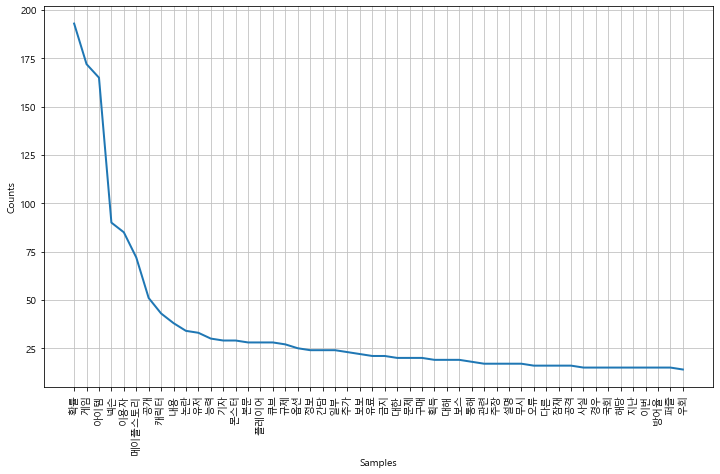

In [28]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(12, 7))
text.plot(50)

### WordCloud 그리기

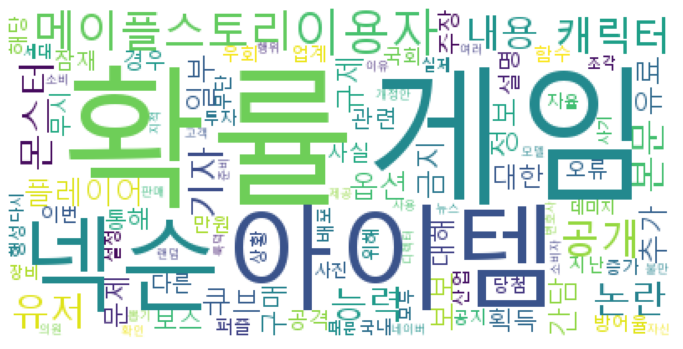

In [29]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

wordcloud = WordCloud(font_path= "c:/Windows/Fonts/malgun.ttf",
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 원하는 이미지를 이용한 워드 클라우드 그리기

In [30]:
from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

mask = np.array(Image.open('heart.jpg'))
image_colors = ImageColorGenerator(mask)

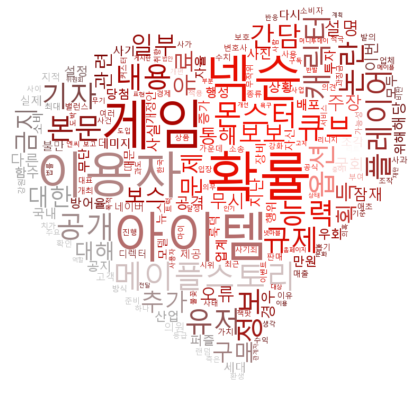

In [31]:
data = text.vocab().most_common(200)

wordcloud = WordCloud(font_path= "c:/Windows/Fonts/malgun.ttf",
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               relative_scaling = 0.1, mask=mask,
               background_color = 'white',
               min_font_size=1,
               max_font_size=100).generate_from_frequencies(dict(data))

default_colors = wordcloud.to_array()

plt.figure(figsize=(10,7))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()